# Imports

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy
import math
import time
import pickle

#TURN 1 FOR DEFENDERS, -1 FOR ATTACKERS

# Game Rules Implementation

The following block of codes implements the rules of the game.

- _isLegal_ checks whether if the move _p1_ -> _p2_ is allowed in _board_: is there a pawn of the right side on _p1_, is _p2_ empty and is there a straight, unblocked path between the two.
- _listOfMoves_ iterates through all the possible moves, and checks whether each one is legal or not using _isLegal_. Then, it returns a list of valid moves.
- _kingCaptured_ checks in all the possible ways if the king has been captured.
- _checkEndgame_ verifies if the king has been captured, or if it has reached the corners, or if there are no attackers left on the board
_ _mightEat_ takes a move as input, and checks whether this move results in one or more piece being eaten. It returns 'eating' information, and the updated board.

In [2]:
def isLegal(board, p1, p2, turn):

    #check if p2 is free
    if board[p2[0]][p2[1]] != 0:
        return False

    #check if p1 has a pawn of the right side
    if (turn==1 and board[p1[0]][p1[1]] not in [1, 2]) or (turn==-1 and board[p1[0]][p1[1]]!=3):
        return False

    #check if both positions are on either the same line or the same column
    if p1[0]!= p2[0] and p1[1]!=p2[1]:
        return False

    #check that they are not the same position
    if p1[0]== p2[0] and p1[1]==p2[1]:
        return False

    #check that no one is in a hostile square (except for a king in the corner)
    if board[p1[0]][p1[1]]!=2 and p2 in [[0,0],[0,6],[6,0],[6,6],[3,3]]:
        return False
    elif p2 in [[3,3]]:
        return False

    #check that all the slots between the two positions are empty, to allow a free passage
    moving_axis=int(p1[0]==p2[0])
    direction=int((int(p2[moving_axis]-p1[moving_axis]>0)-0.5)*2)
    for i in range(abs(p1[0]-p2[0]+p1[1]-p2[1])):
        if board[p1[0]+(1-moving_axis)*(i+1)*direction][p1[1]+(moving_axis)*(i+1)*direction]!=0:
            return False

    return True

def listOfMoves(board, turn):

    list_of_moves=[]

    available_pawns=[]

    #check available moves for the attacker (turn=-1)
    if turn==-1:
        rawpawns=np.where(np.array(board)==3)

        #iterate through all the attackers
        for i in range(rawpawns[0].size):
            this_pawn=[rawpawns[0][i], rawpawns[1][i]]

            #check legality of a move to every square in a cross around the pawn 
            for j in range(7):
                if isLegal(board, this_pawn, [this_pawn[0],j], -1):
                    list_of_moves+=[[this_pawn, [this_pawn[0],j]]]
            for k in range(7):
                if isLegal(board, this_pawn, [k, this_pawn[1]], -1):
                    list_of_moves+=[[this_pawn, [k, this_pawn[1]]]]
    
    #check available moves for the defender (turn=1)
    elif turn==1:
        a=np.where(np.array(board)==1)
        b=np.where(np.array(board)==2)
        rawpawns=[a[0].tolist()+b[0].tolist(),a[1].tolist()+b[1].tolist()]

        #iterate through all the defender
        for i in range(len(rawpawns[0])):
            this_pawn=[rawpawns[0][i], rawpawns[1][i]]

            #check legality of a move to every square in a cross around the pawn 
            for j in range(7):
                if isLegal(board, this_pawn, [this_pawn[0],j], 1):
                    list_of_moves+=[[this_pawn, [this_pawn[0],j]]]
            for k in range(7):
                if isLegal(board, this_pawn, [k, this_pawn[1]], 1):
                    list_of_moves+=[[this_pawn, [k, this_pawn[1]]]]
    
    #return a list of available moves
    return list_of_moves

In [3]:
def kingCaptured(board):
    coordinates_raw=np.where(np.array(board)==2)
    coordinates=[int(coordinates_raw[0]),int(coordinates_raw[1])]

    checks=[[0,1],[1,0],[0,-1],[-1,0]]

    surrounded=4
    first_opponent=False
    first_opponent_dir=-1

    #check whether the king is in the center
    if coordinates in [[3,3]]:
        #return the capture if the king is surrounded on all sides
        if board[2][3]==3 and board[3][2]==3 and board[4][3]==3 and board[3][4]==3:
            return [True, -1]
        return [False, 0]

    #check whether the king is adjacent to the throne
    elif coordinates in [[2,3],[3,2],[4,3],[3,4]]:

        #check whether the king is surrounded by three players (we know no one is on the throne because no legal moves allow it)
        for i in range(4):
            if coordinates[0]+checks[i][0]<7 and coordinates[0]+checks[i][0]>-1 and coordinates[1]+checks[i][1]<7 and coordinates[1]+checks[i][1]>-1:
                if board[coordinates[0]+checks[i][0]][coordinates[1]+checks[i][1]]!=3:
                    surrounded=surrounded-1
        if surrounded==3:
            return [True, -1]
        return [False, 0]
    
    #check if the king has two attackers around itself
    for i in range(2):
        if 0<=coordinates[0]+checks[i][0]<=6 and 0<=coordinates[1]+checks[i][1]<=6 and 0<=coordinates[0]+checks[i+2][0]<=6 and 0<=coordinates[1]+checks[i+2][1]<=6:
            if board[coordinates[0]+checks[i][0]][coordinates[1]+checks[i][1]]==3 and board[coordinates[0]+checks[i+2][0]][coordinates[1]+checks[i+2][1]]==3:
                return [True, -1]
                
    return [False, 0]

#check if the king is in the corner, if there are no attackers left, or if the king is captured
def checkEndgame(board, turn):
    if board[0][0]==2 or board[0][6]==2 or board[6][0]==2 or board[6][6]==2:
        return [True, 1]
    if np.where(np.array(board)==3)[0].size==0:
        return [True, 1]
    if turn==-1:
        return kingCaptured(board)
    else:
        return [False, 0]

In [4]:
def mightEat(board, p2, turn):

    eaten=0

    coordinates_raw=np.where(np.array(board)==2)

    checks=[[0,1],[1,0],[0,-1],[-1,0]]
    two_step=[[0,2],[2,0],[0,-2],[-2,0]]
    dir=['right','up','left','down']

    #check if there is an enemy player next to the p2 of the new move, and if there is a hostile square or a friendly piece on the other side of this enemy piece
    for i in range(4):
        if 0 <= p2[0]+two_step[i][0] <= 6 and 0 <= p2[1]+two_step[i][1] <= 6:
            if board[p2[0]+checks[i][0]][p2[1]+checks[i][1]]==2+turn and (board[p2[0]+two_step[i][0]][p2[1]+two_step[i][1]]==2-turn or [p2[0]+two_step[i][0],p2[1]+two_step[i][1]] in [[0,0],[0,6],[6,0],[6,6]] or ([p2[0]+two_step[i][0],p2[1]+two_step[i][1]] in [[3, 3]] and turn==-1 and board[3][3]!=2) or ([p2[0]+two_step[i][0],p2[1]+two_step[i][1]] in [[3, 3]] and turn==1) or (board[p2[0]+two_step[i][0]][p2[1]+two_step[i][1]]==2 and turn==1)):
                board[p2[0]+checks[i][0]][p2[1]+checks[i][1]]=0
                eaten+=1
    
    return board, eaten

# Game Class

The following class defines a game with its board, information on who plays next (turn) and whether the game is over or not.
It has different types of moves for different usages.

In [5]:
class Game():

    #init class with the beginning board, over set to 0 (False) and turn set to attackers
    def __init__(self):
        init_board=[[0,0,0,3,0,0,0],[0,0,0,3,0,0,0],[0,0,0,1,0,0,0],[3,3,1,2,1,3,3],[0,0,0,1,0,0,0],[0,0,0,3,0,0,0],[0,0,0,3,0,0,0]]
        self.over=0
        self.board=init_board
        self.turn=-1

    #start an existing game from scratch: useful to avoid creating a high number of data structures that will only be used once
    def reset(self):
        init_board=[[0,0,0,3,0,0,0],[0,0,0,3,0,0,0],[0,0,0,1,0,0,0],[3,3,1,2,1,3,3],[0,0,0,1,0,0,0],[0,0,0,3,0,0,0],[0,0,0,3,0,0,0]]
        self.over=0
        self.board=init_board
        self.turn=-1

    #allows a game to start from an existing position
    def preloardBoard(self, new_board, new_turn):
        self.board=copy.deepcopy(new_board)
        self.turn=new_turn

    #human move function, that checks if the move is legal. In practice, I didn't use this function in my trials
    def human_move(self, pos1, pos2):
        p1=[(pos1//10)-1,(pos1%10)-1]
        p2=[(pos2//10)-1,(pos2%10)-1]
        if not isLegal(self.board, p1,  p2, self.turn):
            print('ILLEGAL MOVE')
            return 
             
        self.board[p2[0]][p2[1]]=self.board[p1[0]][p1[1]]
        self.board[p1[0]][p1[1]]=0
        self.board=mightEat(self.board, p2, self.turn)
        self.turn=-self.turn
        return checkEndgame(self.board, -self.turn)

    #this function plays a move on a board. It assumes that the move was played by an agent that already checks for 
    #legal moves, so it doesn't check them
    def AImove(self, p1, p2):
        if p1 in [[10,10]]:
            return [True, -self.turn]
        self.board[p2[0]][p2[1]]=self.board[p1[0]][p1[1]]
        self.board[p1[0]][p1[1]]=0
        self.board, eaten=mightEat(self.board, p2, self.turn)
        self.turn=-self.turn
        return checkEndgame(self.board, -self.turn)

    #works the same as the function above, but reaturn whether pieces have been eaten. I planned on using piece eating
    #as reward, but ended up not doing so
    def RewardMove(self, p1, p2):
        if p1 in [[10,10]]:
            return [True, -self.turn]
        self.board[p2[0]][p2[1]]=self.board[p1[0]][p1[1]]
        self.board[p1[0]][p1[1]]=0
        self.board, eaten=mightEat(self.board, p2, self.turn)
        self.turn=-self.turn
        return checkEndgame(self.board, -self.turn), eaten

    #returns the result of one single move, without updating the turn or other information (assumes no other move will be played)
    #useful to compute what the board would look like after a potential move
    def SimuMove(self, p1, p2):
        if p1[0]<0 or p1[0]>6:
            return True, -self.turn, self.board
        self.board[p2[0]][p2[1]]=self.board[p1[0]][p1[1]]
        self.board[p1[0]][p1[1]]=0
        self.board, eaten=mightEat(self.board, p2, self.turn)
        return checkEndgame(self.board, self.turn), eaten, self.board

    #display a board 
    def disp(self):
        print(' ')
        for line in self.board:
            print(line)


The following blocks define two first players: a random player, and a human player.

For a player to work properly, it needs a function _moveChoice()_ which, given a board and a turn, will choose the next move according to that player's policy. If there are no possible moves available, these functions return [[10,10],[10,10]]. In this case, the Game class will realise there are no moves available yet, and declare the defeat of the corresponding player. 

#### Random Player

In [6]:
class Random_Player():

    def __init__(self):
        self.mode=0
        self.step=0

    def moveChoice(self, board, turn):
        movelist=listOfMoves(board, turn)

        if len(movelist)==0:
            return [[10, 10], [10, 10]]

        #simply choose a random move in all the available ones
        return random.choice(movelist)

#### Human Player

In [7]:
class Human_Player():

    def __init__(self):
        self.mode=0
        self.step=0

    def moveChoice(self, board, turn):

        #ask a player for the move in x1y1,x2y2 format
        move=input('Your move: \n')
        b=move.split(",")
        
        return [[int(b[0])//10, int(b[0])%10],[int(b[1])//10, int(b[1])%10]]

# Heuristic Players — Hugin & Munin

In [8]:
class Hugin():

    #the init class defines a set of weights
    def __init__(self, weights):
        self.weights=weights
        self.step=0
        
    def moveChoice(self, board, turn):

        #establish a list of moves
        checks=[[0,1],[0,-1],[1,0],[-1,0]]
        movelist=listOfMoves(board, -1)
        scores=np.zeros((len(movelist)))

        if len(movelist)==0:
            return [[10, 10], [10, 10]]

        a=np.where(np.array(board)==1)
        b=np.where(np.array(board)==2)
        rawpawns=[a[0].tolist()+b[0].tolist(),a[1].tolist()+b[1].tolist()]

        nb_enemy=len(rawpawns[0])
        simu=Game()

        #loop across all the possible moves
        for i in range(len(movelist)):
            simu.reset()
            move=movelist[i]
            simu.preloardBoard(board, -1)
            endgame, eaten, newboard = simu.SimuMove(move[0],move[1])
            
            #if the move results in an immediate victory, return it
            #if the move results in an immediate defeat, set it to score -1
            if endgame[0]:
                if endgame[1]==-1:
                    scores[i]=1
                    return move
                else:
                    scores[i]=-1
                    continue
            
            #number of defenders and attackers
            new_nb_enemy=nb_enemy-eaten
            ours=np.where(np.array(newboard)==3)

            #number of columns and rows covered by attacker pieces
            coverage=len(set(ours[0].tolist()))+len(set(ours[1].tolist()))
            king_surrounded=0

            #how many players is the king surrounded by 
            for j in range(4):
                king_pos=[b[0].tolist()[0], b[1].tolist()[0]]
                if 0<=king_pos[0]+checks[j][0]<=6 and 0<=king_pos[1]+checks[j][1]<=6:
                    if newboard[king_pos[0]+checks[j][0]][king_pos[1]+checks[j][1]]==3 or [king_pos[0]+checks[j][0],king_pos[1]+checks[j][1]] in [[3,3]]:
                        king_surrounded+=1
            
            #how many corner-adjacent blocks are covered by attackers
            protected=0
            corners=[[1,0],[0,1],[5,0],[0,5],[1,6],[6,1],[5,6],[6,5]]
            for k in range(8):
                if newboard[corners[k][0]][corners[k][1]]==3:
                    protected+=1

            #return a product of weights and the feature vector
            scores[i]= self.weights[0]*(1-new_nb_enemy/5) + self.weights[1]*(coverage/14) + self.weights[2]*(king_surrounded/4) + self.weights[3]*(protected/8)

        return movelist[np.random.choice(np.flatnonzero(scores == scores.max()))]     

In [9]:
class Munin():

    #the init class defines a set of weights
    def __init__(self, weights):
        self.weights=weights
        self.step=0
        
    def moveChoice(self, board, turn):

        #establish a list of moves
        checks=[[0,1],[0,-1],[1,0],[-1,0]]
        movelist=listOfMoves(board, 1)
        scores=np.zeros((len(movelist)))

        if len(movelist)==0:
            return [[10, 10], [10, 10]]

        nb_enemy=len(np.where(np.array(board)==3)[0])
        simu=Game()

        #loop across all the possible moves
        for i in range(len(movelist)):
            simu.reset()
            move=movelist[i]
            simu.preloardBoard(board, 1)
            endgame, eaten, newboard = simu.SimuMove(move[0],move[1])
            
            #if the move results in an immediate victory, return it
            #if the move results in an immediate defeat, set it to score -1
            if endgame[0]:
                if endgame[1]==1:
                    scores[i]=1
                    return move
                else:
                    scores[i]=-1
                    continue
            
            #number of defenders
            new_nb_enemy=nb_enemy-eaten


            a=np.where(np.array(newboard)==1)
            b=np.where(np.array(newboard)==2)
            rawpawns=[a[0].tolist()+b[0].tolist(),a[1].tolist()+b[1].tolist()]

            #number of columns and rows covered by defender pieces
            coverage=len(set(rawpawns[0]))+len(set(rawpawns[1]))
            
            king_surrounded=0

            #how many players is the king surrounded by
            for j in range(4):
                king_pos=[b[0].tolist()[0], b[1].tolist()[0]]
                if 0<=king_pos[0]+checks[j][0]<=6 and 0<=king_pos[1]+checks[j][1]<=6:
                    if newboard[king_pos[0]+checks[j][0]][king_pos[1]+checks[j][1]]==3 or [king_pos[0]+checks[j][0],king_pos[1]+checks[j][1]] in [[3,3]]:
                        king_surrounded+=1


            #check how close the king is from one of corners, and how far from the throne
            cordis=min(abs(king_pos[0])+abs(king_pos[1]),abs(king_pos[0])+abs(6-king_pos[1]),abs(6-king_pos[0])+abs(king_pos[1]),abs(6-king_pos[0])+abs(6-king_pos[1]))
            center_corner_axis=(abs(3-king_pos[0])+abs(3-king_pos[1]))+(6-cordis)

            #return a product of weights and the feature vector
            scores[i]= self.weights[0]*(1-new_nb_enemy/8) + self.weights[1]*(coverage/10) + self.weights[2]*(1-king_surrounded/4) + self.weights[3]*center_corner_axis/12
        return movelist[np.random.choice(np.flatnonzero(scores == scores.max()))]     

# Monte-Carlo Player — Odin

The following block defines the Monte-Carlo Player Odin.

In [10]:
class Odin():

    #define all the parameters of Monte-Carlo Player. How many moves will be checked, how deep, when to stop, and the weight heuristic vectors
    def __init__(self, width, depth, max_runs, all_weights):
        self.width=width
        self.depth=depth
        self.max_runs=max_runs
        self.attack_weights=all_weights[0]
        self.defend_weights=all_weights[1]
        self.step=0

    #return the Hugin/Munin heuristic 
    def returnHeuristic(self, board, turn):
        
        checks=[[0,1],[0,-1],[1,0],[-1,0]]

        #if it is defender's turn, copy the functioning of Munin
        if turn==1:
            
            weights=self.defend_weights
            movelist=listOfMoves(board, 1)
            scores=np.zeros((len(movelist)))

            if len(movelist)==0:
                return 10
            if len(movelist)==1:
                return np.array([movelist[0]])

            nb_enemy=len(np.where(np.array(board)==3)[0])
            simu=Game()

            for i in range(len(movelist)):
                simu.reset()
                move=movelist[i]
                simu.preloardBoard(board, 1)
                endgame, eaten, newboard = simu.SimuMove(move[0],move[1])

                if endgame[0]:
                    if endgame[1]==1:
                        scores[i]=1
                        return np.array([move])
                    else:
                        scores[i]=-1
                        continue
            
                new_nb_enemy=nb_enemy-eaten


                a=np.where(np.array(newboard)==1)
                b=np.where(np.array(newboard)==2)
                rawpawns=[a[0].tolist()+b[0].tolist(),a[1].tolist()+b[1].tolist()]
                coverage=len(set(rawpawns[0]))+len(set(rawpawns[1]))
                king_surrounded=0

                for j in range(4):
                    king_pos=[b[0].tolist()[0], b[1].tolist()[0]]
                    if 0<=king_pos[0]+checks[j][0]<=6 and 0<=king_pos[1]+checks[j][1]<=6:
                        if newboard[king_pos[0]+checks[j][0]][king_pos[1]+checks[j][1]]==3 or [king_pos[0]+checks[j][0],king_pos[1]+checks[j][1]] in [[3,3]]:
                            king_surrounded+=1


                cordis=min(abs(king_pos[0])+abs(king_pos[1]),abs(king_pos[0])+abs(6-king_pos[1]),abs(6-king_pos[0])+abs(king_pos[1]),abs(6-king_pos[0])+abs(6-king_pos[1]))
                center_corner_axis=(abs(3-king_pos[0])+abs(3-king_pos[1]))+(6-cordis)

                scores[i]= weights[0]*(1-new_nb_enemy/8) + weights[1]*(coverage/10) + weights[2]*(1-king_surrounded/4) + weights[3]*center_corner_axis/12

            temp = list(zip(scores.tolist(), movelist))
            random.shuffle(temp)
            res1, res2 = zip(*temp)
            scores, movelist = np.array(list(res1)), np.array(list(res2))

            #returns the top 'width' moves instead of the first one only 
            max_moves=min(len(movelist),self.width)
            topindicies=np.argpartition(scores, -max_moves)[-max_moves:]
            npmoves=np.array(movelist)
            
            return npmoves[topindicies]

        #if it is attacker's turn, copy the functioning of Hugin
        else:

            weights=self.attack_weights
            movelist=listOfMoves(board, -1)
            scores=np.zeros((len(movelist)))

            if len(movelist)==0:
                return 10
            if len(movelist)==1:
                return np.array([movelist[0]])

            a=np.where(np.array(board)==1)
            b=np.where(np.array(board)==2)
            rawpawns=[a[0].tolist()+b[0].tolist(),a[1].tolist()+b[1].tolist()]

            nb_enemy=len(rawpawns[0])
            simu=Game()

            for i in range(len(movelist)):
                simu.reset()
                move=movelist[i]
                simu.preloardBoard(board, -1)
                endgame, eaten, newboard = simu.SimuMove(move[0],move[1])
            
                if endgame[0]:
                    if endgame[1]==-1:
                        scores[i]=1
                        return np.array([move])
                    else:
                        scores[i]=-1
                        continue
            
                new_nb_enemy=nb_enemy-eaten
                ours=np.where(np.array(newboard)==3)
                coverage=len(set(ours[0].tolist()))+len(set(ours[1].tolist()))
                king_surrounded=0

                for j in range(4):
                    king_pos=[b[0].tolist()[0], b[1].tolist()[0]]
                    if 0<=king_pos[0]+checks[j][0]<=6 and 0<=king_pos[1]+checks[j][1]<=6:
                        if newboard[king_pos[0]+checks[j][0]][king_pos[1]+checks[j][1]]==3 or [king_pos[0]+checks[j][0],king_pos[1]+checks[j][1]] in [[3,3]]:
                            king_surrounded+=1

                protected=0
                corners=[[1,0],[0,1],[5,0],[0,5],[1,6],[6,1],[5,6],[6,5]]
                for k in range(8):
                    if newboard[corners[k][0]][corners[k][1]]==3:
                        protected+=1


                scores[i]= weights[0]*(1-new_nb_enemy/5) + weights[1]*(coverage/14) + weights[2]*(king_surrounded/4) + weights[3]*(protected/8)

            temp = list(zip(scores.tolist(), movelist))
            random.shuffle(temp)
            res1, res2 = zip(*temp)
            scores, movelist = np.array(list(res1)), np.array(list(res2))
            
            #returns the top 'width' moves instead of the first one only 
            max_moves=min(len(movelist),self.width)
            topindicies=np.argpartition(scores, -max_moves)[-max_moves:]
            npmoves=np.array(movelist)

            return npmoves[topindicies]
    
    #return the best move according to monte carlo
    def MCTS_Winner(self, board, movelist, turn):
        
        #create the two players that will be used for Monte-Carlo
        if turn==1:
            player_one=Munin(self.defend_weights)
            player_two=Hugin(self.attack_weights)
        else:
            player_two=Munin(self.defend_weights)
            player_one=Hugin(self.attack_weights)

        evaluations=np.ones((np.size(movelist,0)))
        final_evaluations=np.ones((np.size(movelist,0)))
        exploration=np.ones((np.size(movelist,0)))
        wins=np.ones((np.size(movelist,0)))
        trygame=Game()
        runs=0

        #until we have reached the maximum number of runs, choose the move with the maximum constant
        while runs < self.max_runs:
            i=np.random.choice(np.flatnonzero(evaluations == evaluations.max()))
            move=movelist[i].tolist()
            trygame.reset()
            trygame.preloardBoard(board, turn)
            over=0

            trygame.AImove(move[0], move[1])

            #play a virtual game between the two players starting with the corresponding move
            #until depth indicated by the parameters
            for j in range(self.depth):
                movement=player_two.moveChoice(trygame.board, trygame.turn)
                over, victory=trygame.AImove(movement[0], movement[1])
                if over:
                    break
                movement=player_one.moveChoice(trygame.board, trygame.turn)
                over, victory=trygame.AImove(movement[0], movement[1])
                if over:
                   break
            if (victory==1 and turn==1) or (victory==-1 and turn==-1):
                wins[i]+=1
            exploration[i]+=1

            #update all the constants depending on who won this game (current or enemy player)
            runs+=1 
            for k in range(len(movelist)):
                evaluations[k]=(wins[k]/exploration[k])+np.sqrt(2)*((math.log(runs)/exploration[k])**(1/2))

        for q in range(len(movelist)):
                final_evaluations[q]=(wins[q]/exploration[q])
        
        #return the move with the maximum score
        return movelist[np.random.choice(np.flatnonzero(final_evaluations == final_evaluations.max()))]

    #return the best move according to MCTS 
    def moveChoice(self, board, turn):

        movelist=self.returnHeuristic(board, turn)

        if isinstance(movelist, int):
            return [[10,10],[10,10]]

        winner=self.MCTS_Winner(board, movelist, turn)
        return winner.tolist()

# Monte-Carlo Explorer — Leif

The following block defines the Monte-Carlo Player Leif. It is a copy of Odin, except it has an 'explorer' player as a initializing constant. One move out of five, Leif will choose a move using the explorer policy (in this case, the Random Policy) instead of the Monte-Carlo one.

In [11]:
class Leif():
    def __init__(self, width, depth, max_runs, all_weights):
        self.width=width
        self.depth=depth
        self.max_runs=max_runs
        self.attack_weights=all_weights[0]
        self.defend_weights=all_weights[1]
        self.step=0

        #defining the explorer
        self.explorer=Random_Player()

    def returnHeuristic(self, board, turn):
        
        checks=[[0,1],[0,-1],[1,0],[-1,0]]

        if turn==1:
            
            weights=self.defend_weights
            movelist=listOfMoves(board, 1)
            scores=np.zeros((len(movelist)))

            if len(movelist)==0:
                return 10
            if len(movelist)==1:
                return np.array([movelist[0]])

            nb_enemy=len(np.where(np.array(board)==3)[0])
            simu=Game()

            for i in range(len(movelist)):
                simu.reset()
                move=movelist[i]
                simu.preloardBoard(board, 1)
                endgame, eaten, newboard = simu.SimuMove(move[0],move[1])

                if endgame[0]:
                    if endgame[1]==1:
                        scores[i]=1
                        return np.array([move])
                    else:
                        scores[i]=-1
                        continue
            
                new_nb_enemy=nb_enemy-eaten


                a=np.where(np.array(newboard)==1)
                b=np.where(np.array(newboard)==2)
                rawpawns=[a[0].tolist()+b[0].tolist(),a[1].tolist()+b[1].tolist()]
                coverage=len(set(rawpawns[0]))+len(set(rawpawns[1]))
                king_surrounded=0

                for j in range(4):
                    king_pos=[b[0].tolist()[0], b[1].tolist()[0]]
                    if 0<=king_pos[0]+checks[j][0]<=6 and 0<=king_pos[1]+checks[j][1]<=6:
                        if newboard[king_pos[0]+checks[j][0]][king_pos[1]+checks[j][1]]==3 or [king_pos[0]+checks[j][0],king_pos[1]+checks[j][1]] in [[3,3]]:
                            king_surrounded+=1


                cordis=min(abs(king_pos[0])+abs(king_pos[1]),abs(king_pos[0])+abs(6-king_pos[1]),abs(6-king_pos[0])+abs(king_pos[1]),abs(6-king_pos[0])+abs(6-king_pos[1]))
                center_corner_axis=(abs(3-king_pos[0])+abs(3-king_pos[1]))+(6-cordis)

                scores[i]= weights[0]*(1-new_nb_enemy/8) + weights[1]*(coverage/10) + weights[2]*(1-king_surrounded/4) + weights[3]*center_corner_axis/12

            temp = list(zip(scores.tolist(), movelist))
            random.shuffle(temp)
            res1, res2 = zip(*temp)
            scores, movelist = np.array(list(res1)), np.array(list(res2))

            max_moves=min(len(movelist),self.width)
            topindicies=np.argpartition(scores, -max_moves)[-max_moves:]
            npmoves=np.array(movelist)
            return npmoves[topindicies]

        else:

            weights=self.attack_weights
            movelist=listOfMoves(board, -1)
            scores=np.zeros((len(movelist)))

            if len(movelist)==0:
                return 10
            if len(movelist)==1:
                return np.array([movelist[0]])

            a=np.where(np.array(board)==1)
            b=np.where(np.array(board)==2)
            rawpawns=[a[0].tolist()+b[0].tolist(),a[1].tolist()+b[1].tolist()]

            nb_enemy=len(rawpawns[0])
            simu=Game()

            for i in range(len(movelist)):
                simu.reset()
                move=movelist[i]
                simu.preloardBoard(board, -1)
                endgame, eaten, newboard = simu.SimuMove(move[0],move[1])
            
                if endgame[0]:
                    if endgame[1]==-1:
                        scores[i]=1
                        return np.array([move])
                    else:
                        scores[i]=-1
                        continue
            
                new_nb_enemy=nb_enemy-eaten
                ours=np.where(np.array(newboard)==3)
                coverage=len(set(ours[0].tolist()))+len(set(ours[1].tolist()))
                king_surrounded=0

                for j in range(4):
                    king_pos=[b[0].tolist()[0], b[1].tolist()[0]]
                    if 0<=king_pos[0]+checks[j][0]<=6 and 0<=king_pos[1]+checks[j][1]<=6:
                        if newboard[king_pos[0]+checks[j][0]][king_pos[1]+checks[j][1]]==3 or [king_pos[0]+checks[j][0],king_pos[1]+checks[j][1]] in [[3,3]]:
                            king_surrounded+=1

                protected=0
                corners=[[1,0],[0,1],[5,0],[0,5],[1,6],[6,1],[5,6],[6,5]]
                for k in range(8):
                    if newboard[corners[k][0]][corners[k][1]]==3:
                        protected+=1


                scores[i]= weights[0]*(1-new_nb_enemy/5) + weights[1]*(coverage/14) + weights[2]*(king_surrounded/4) + weights[3]*(protected/8)

            temp = list(zip(scores.tolist(), movelist))
            random.shuffle(temp)
            res1, res2 = zip(*temp)
            scores, movelist = np.array(list(res1)), np.array(list(res2))
            
            max_moves=min(len(movelist),self.width)
            topindicies=np.argpartition(scores, -max_moves)[-max_moves:]
            npmoves=np.array(movelist)
            return npmoves[topindicies]
    

    def MCTS_Winner(self, board, movelist, turn):

        if turn==1:
            player_one=Munin(self.defend_weights)
            player_two=Hugin(self.attack_weights)
        else:
            player_two=Munin(self.defend_weights)
            player_one=Hugin(self.attack_weights)

        evaluations=np.ones((np.size(movelist,0)))
        final_evaluations=np.ones((np.size(movelist,0)))
        exploration=np.ones((np.size(movelist,0)))
        wins=np.ones((np.size(movelist,0)))
        trygame=Game()
        runs=0


        while runs < self.max_runs:
            i=np.random.choice(np.flatnonzero(evaluations == evaluations.max()))
            move=movelist[i].tolist()
            trygame.reset()
            trygame.preloardBoard(board, turn)
            over=0

            trygame.AImove(move[0], move[1])

            for j in range(self.depth):
                movement=player_two.moveChoice(trygame.board, trygame.turn)
                over, victory=trygame.AImove(movement[0], movement[1])
                if over:
                    break
                movement=player_one.moveChoice(trygame.board, trygame.turn)
                over, victory=trygame.AImove(movement[0], movement[1])
                if over:
                   break
            if (victory==1 and turn==1) or (victory==-1 and turn==-1):
                wins[i]+=1
            exploration[i]+=1

            runs+=1 
            for k in range(len(movelist)):
                evaluations[k]=(wins[k]/exploration[k])+np.sqrt(2)*((math.log(runs)/exploration[k])**(1/2))

        for q in range(len(movelist)):
                final_evaluations[q]=(wins[q]/exploration[q])
        
        return movelist[np.random.choice(np.flatnonzero(final_evaluations == final_evaluations.max()))]

    def moveChoice(self, board, turn):

        #if a random number is under 0.2 (1 out of 5 moves), choose a move using the explorer policy
        willbeexp=random.random()
        if willbeexp<0.2:
            return self.explorer.moveChoice(board, turn)

        movelist=self.returnHeuristic(board, turn)

        if isinstance(movelist, int):
            return [[10,10],[10,10]]

        one_simu=Game()

        for i in range(len(movelist)):
            one_simu.reset()
            move=movelist[i]
            one_simu.preloardBoard(board, turn)
            endgame, eaten, newboard = one_simu.SimuMove(move[0],move[1])
            
            if endgame[0]:
                if endgame[1]==turn:
                    return np.array(move).tolist()

        winner=self.MCTS_Winner(board, movelist, turn)
        return winner.tolist()

# Running Games

The following block runs a certain number of games, it is useful for algorithm testing.

In [12]:
def runGames(attacker, defender, nb_runs):

    ga=Game()
    start=time.time()
    i=0
    games=0
    over=False
    defender_wins=0
    attacker_wins=0
    defender_last_wins=0
    attacker_last_wins=0
    avg_length=0
    lengths=np.zeros((nb_runs))

    #keep playing games until reaching the limit given as an input
    while games<nb_runs:
        ga.reset()
        over=0
        j=0

        #keep playing until either a player wins, or each player has played 100 moves (then declare a draw)
        #most games last between 10 and 25 moves, so the 200 total moves bound is very rarely attained
        for i in range(100):
            movement=attacker.moveChoice(ga.board, ga.turn)
            over, victory=ga.AImove(movement[0], movement[1])
            j=j+1
            if over:
                defender.step=0
                attacker.step=0
                break
            movement=defender.moveChoice(ga.board, ga.turn)
            over, victory=ga.AImove(movement[0], movement[1])
            j=j+1
            if over:
                defender.step=0
                attacker.step=0
                break
        avg_length+=j/nb_runs

        #depending on the winner, update the stats
        if victory==1:
            defender_wins+=1
            defender_last_wins+=1
        elif victory==-1:
            attacker_wins+=1
            attacker_last_wins+=1
        lengths[games]=j
        games+=1

        #after each block of 50 games, display the time needed to play the games and the stats of the last 50 games
        if (games+1)%50==0:
            current=time.time()
            print('Time '+str(current-start))
            start=current
            print('Game '+str(games+1))
            print('Defender victory rate over the last 50 games: '+str(defender_last_wins/50))
            print('Attacker victory rate over the last 50 games: '+str(attacker_last_wins/50))
            #print(defender.weights)
            defender_last_wins=0
            attacker_last_wins=0

    return defender_wins, attacker_wins, avg_length, lengths

Typical game-running block

Time 135.85691285133362
Game 50
Defender victory rate over the last 50 games: 0.78
Attacker victory rate over the last 50 games: 0.2
Time 165.112122297287
Game 100
Defender victory rate over the last 50 games: 0.84
Attacker victory rate over the last 50 games: 0.16
Defender Score: 82.0 %
Attacker Score: 18.0 %
Average game length: 14.54 moves


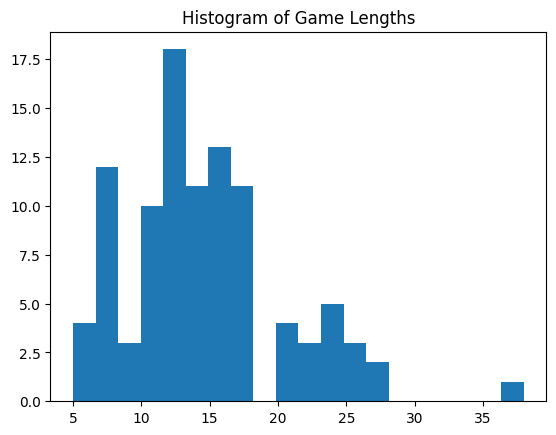

In [49]:

'''
Heuristic PLayers:

#defender=Munin([0.2, 0.1, 0.2, 0.5])
#attacker=Hugin([0.35, 0.2, 0.35, 0.1])

Leif Explorers:

attacker=Leif(3,10,10,[[0.35, 0.2, 0.35, 0.1],[0.2, 0.1, 0.2, 0.5]])
defender=Leif(3,10,10,[[0.35, 0.2, 0.35, 0.1],[0.2, 0.1, 0.2, 0.5]])

Boosted Leif Explorers:

attacker=Leif(6,10,25,[[0.35, 0.2, 0.35, 0.1],[0.2, 0.1, 0.2, 0.5]])
defender=Leif(6,10,25,[[0.35, 0.2, 0.35, 0.1],[0.2, 0.1, 0.2, 0.5]])

Fast Odins:

attacker=Odin(5,5,20,[[0.35, 0.2, 0.35, 0.1],[0.2, 0.1, 0.2, 0.5]])
defender=Odin(5,5,20,[[0.35, 0.2, 0.35, 0.1],[0.2, 0.1, 0.2, 0.5]])

Angry Odins:

#defender=Odin(40,5,250,[[0.35, 0.1, 0.35, 0.2],[0.15, 0.05, 0.2, 0.6]])
#attacker=Odin(40,5,250,[[0.35, 0.1, 0.35, 0.2],[0.15, 0.05, 0.2, 0.6]])

Other:

attacker=Human_Player()
attacker=Random_Player()


'''


#best paremeters Hugin: 0.35, 0.2, 0.35, 0.1 (nb_enemy, coverage, surrounded, protected)
#best parameters Munin: 0.2, 0.1, 0.2, 0.5 (nb_enemy, coverage, surrounded, center-corner)
#best parameters Odin: ???? (width, depth, max_runs, [[attack_weights],[defense_weights]])

attacker=Leif(3,10,10,[[0.35, 0.2, 0.35, 0.1],[0.2, 0.1, 0.2, 0.5]])
defender=Odin(5,5,20,[[0.35, 0.2, 0.35, 0.1],[0.2, 0.1, 0.2, 0.5]])

nb_runs=100
defender_wins, attacker_wins, avg_length, lengths = runGames(attacker, defender, nb_runs)

print('Defender Score: '+str(100*defender_wins/nb_runs)+' %')
print('Attacker Score: '+str(100*attacker_wins/nb_runs)+' %')
print('Average game length: '+str(round(avg_length,4))+' moves')
plt.hist(lengths, bins=20)
plt.title('Histogram of Game Lengths')
plt.show()

### Some Constants

In [13]:
discount=0.99
n_bootstrap=10

### Board Bin

In [14]:
class BoardBin():

    def __init__(self, size):
        self.bbin=np.zeros((size,51))
        self.count=0
        self.size=size

    #add a board to the list, and two more values: the turn, and the outcome
    #these values are set to 20 by default but are meant to be changed
    def addBoard(self, board, turn):
        if self.count>=self.size:
            return 0
        lineboard=np.array(board).flatten()
        line=np.concatenate((lineboard,np.array([20,20])))
        self.bbin[self.count]=line
        self.bbin[self.count][49]=turn
        return self.count

    #add the outcome after placing a board
    def addOutcome(self, outcome):
        if self.count>=self.size:
            return 0
        self.bbin[self.count][50]=outcome
        self.count+=1
        return
    
    #same function, but adding a return. In practice, these functions are used
    #interchangeably
    def addReturn(self, return_):
        if self.count>=self.size:
            return 0
        self.bbin[self.count][50]=return_
        self.count+=1
        return

    #display a board, its turn and its outcome or return
    def dispBoard(self, index):
        for i in range(7):
            print(self.bbin[index][7*i+0:7*i+7])
        print('Turn: '+str(self.bbin[index][49])) 
        print('Final Outcome/Return: '+str(self.bbin[index][50]))

    #return the list of boards
    def getBoards(self):
        new_bbins=copy.deepcopy(self.bbin)
        return new_bbins


Loading the Bins computed before

In [15]:
with open('Games_Bin_679k.pkl', 'rb') as f:
    Games_Bin = pickle.load(f)

# Bin Treatment

The following block rotates each board in the bin until the king is in the upper-left part of the board (or in the center block).
This reduces the overall variance of boards and makes computing weights or analyzing boards much easier using a the database.

Of course, this means that anytime we want to use a model or a database to compute the reward of a move, its corresponding board will need to be rotated as well.

In [16]:
Rotated_Bins=copy.deepcopy(Games_Bin.bbin[:Games_Bin.count,:])
for i in range(Games_Bin.count):
    king_place=np.where(Rotated_Bins[i,:]==2)[0][0]
    if king_place%7<3 and king_place//7>=3:
        Rotated_Bins[i,0:49]=(np.rot90(np.reshape(Rotated_Bins[i,0:49],(7,7)),3)).flatten()
    elif king_place%7>=3 and king_place//7>=4:
        Rotated_Bins[i,0:49]=(np.rot90(np.reshape(Rotated_Bins[i,0:49],(7,7)),2)).flatten()
    elif king_place%7>=4 and king_place//7<4:
        Rotated_Bins[i,0:49]=(np.rot90(np.reshape(Rotated_Bins[i,0:49],(7,7)),1)).flatten()

This block prepares a filter for similarity checks. When computing the similarity of a boards, we want some slots to count more than others. Typically: the corner-adjacent square, the blocks directly next to the king, the blocks that the king can reach in one move.

In [17]:
def filterMaker(position):
    to_check=[[0,-1],[0, 1], [1, 0], [-1, 0],[1,-1],[1, 1], [-1, 1], [-1, -1],[0,-2],[0,-3],[0,-4],[0,-5],[0,-6],[0,2],[0,3],[0,4],[0,5],[0,6],[-2, 0],[-3, 0],[-4, 0],[-5, 0],[-6,0],[2, 0],[3, 0],[4, 0],[5, 0],[6,0]]
    
    #defining the first 'early' filter
    filter=np.array([[0,1,0,0,0,1,0],[1,0,0,0,0,0,1],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[1,0,0,0,0,0,1],[0,1,0,0,0,1,0]])

    #defining a second layer of filter with all the blocks to check, and their position relative to the king
    for i in range(len(to_check)):
        new_pos=[position[0]+to_check[i][0], position[1]+to_check[i][1]]
        if 0<=new_pos[0]<=6 and 0<=new_pos[1]<=6 and (new_pos not in [[0,1],[1,0],[0,5],[1,6],[5,0],[5,6],[6,1],[6,5],[0,0],[0,6],[6,0],[6,6],[3,3]]):
            filter[new_pos[0]][new_pos[1]]=1
    filter=filter.flatten()

    #transform all the 0's in 0.1's in the filters, we still want the 'uninteresting' slots to count
    filter=np.multiply(filter,0.9)
    filter=np.add(filter,0.1)
    return filter

In [18]:
#prepare a filter for all 13 positions of the king

list_of_kingpos=[0,1,2,3,7,8,9,10,14,15,16,17,24]
filter_List=np.zeros((13,49))
filter_Sums=np.zeros((13))
for i in range(len(list_of_kingpos)):
    position=[list_of_kingpos[i]//7,list_of_kingpos[i]%7]
    filter_List[i]=filterMaker(position)
    filter_Sums[i]=np.sum(filter_List[i])

In [19]:
Binary_Rotated_Bins=copy.deepcopy(Rotated_Bins)

#transform the 3 in -1's to make computations more intuitive
Binary_Rotated_Bins[Binary_Rotated_Bins==3]=-1

#Create two sets of bins, that will sort boards by turn and king position
Att_Rotated_Filtered=np.zeros((13,500000,51))
Def_Rotated_Filtered=np.zeros((13,500000,51))
Att_rfcounts=np.zeros((13))
Def_rfcounts=np.zeros((13))

#add each board in the Bin depending on their turn and king position
for j in range(len(Binary_Rotated_Bins)):
    king_pos=np.where(Binary_Rotated_Bins[j]==2)[0][0]
    bin_index=np.where(list_of_kingpos==king_pos)[0]
    if Binary_Rotated_Bins[j,49]==1:
        Def_Rotated_Filtered[bin_index, int(Def_rfcounts[bin_index])]=Binary_Rotated_Bins[j]
        Def_rfcounts[bin_index]+=1
    if Binary_Rotated_Bins[j,49]==-1:
        Att_Rotated_Filtered[bin_index, int(Att_rfcounts[bin_index])]=Binary_Rotated_Bins[j]
        Att_rfcounts[bin_index]+=1

In [20]:
#number of board in each bin
#there is not a single position in the attacker bin 0: this corresponds to the king being in the corner, which if it happens, stops the game immediately.
print(Att_rfcounts)
print(Def_rfcounts)

[     0.  10176.  10189.  12568.  10079.  17015.  19595.  19932.  10415.
  19312.  21623.  55951. 128047.]
[ 39069.  10175.  10216.  12376.  10072.  16997.  19593.  19258.  10420.
  19341.  21364.  53290. 102627.]


The following function gets the reward of a board according to the database.

In [21]:
def getRewardFromBase(board, turn, n_bootstrap):

    board[board==3]=-1
    king_place=np.where(board==2)[0][0]
    rotated_board=board

    #rotate the current board
    if king_place%7<3 and king_place//7>=3:
        rotated_board=(np.rot90(np.reshape(rotated_board,(7,7)),3)).flatten()
    elif king_place%7>=3 and king_place//7>=4:
        rotated_board=(np.rot90(np.reshape(rotated_board,(7,7)),2)).flatten()
    elif king_place%7>=4 and king_place//7<4:
        rotated_board=(np.rot90(np.reshape(rotated_board,(7,7)),1)).flatten()
    
    king_pos=np.where(rotated_board==2)[0][0]
    bin_index=np.where(list_of_kingpos==king_pos)[0]
    
    #select the right bin depending on the position of the king
    if turn==1:
        Rotated_Filtered=Def_Rotated_Filtered
        rfcounts=Def_rfcounts
    if turn==-1:
        Rotated_Filtered=Att_Rotated_Filtered
        rfcounts=Att_rfcounts

    #select the best n_bootstrap positions according to their resemblance with the current board
    mean_collection=np.mean(filter_List[bin_index]*[np.squeeze(Rotated_Filtered[bin_index,0:int(rfcounts[bin_index]),0:49])==rotated_board],2)[0]
    best_positions = np.argpartition(mean_collection, -n_bootstrap)[-n_bootstrap:]

    #return the average reward of these resemblant positions, times the average resemblance of the database to the current board
    #if this resemblance is low, this means the algorithm's guess should be taken less seriously — bringing the score towards 0
    score=0
    for position in best_positions:
        score+=(Rotated_Filtered[bin_index,position,50]/n_bootstrap)*np.mean(mean_collection)
    return score

# Reinforcement Learning Player — Thor

This block creates the player Thor

In [22]:
class Thor():
    def __init__(self, bootstrap_number):
        self.bootstrap_number=bootstrap_number
        self.simu=Game()

    def moveChoice(self, board, turn):
        movelist=listOfMoves(board, turn)
        scores=np.ones((len(movelist)))*(-20)
        if len(movelist)==0:
            return [[10,10],[10,10]]

        #iterates through all the moves, compute their score
        #their score must be mutliplied by the turn, to makes sure that the attacker is indeed looking for the lowest outcome possible
        for i in range(len(movelist)):
            self.simu.reset()
            move=movelist[i]
            self.simu.preloardBoard(board, turn)
            endgame, eaten, newboard = self.simu.SimuMove(move[0],move[1])
            newboard_to_send=copy.deepcopy(newboard)
            scores[i]=getRewardFromBase(np.array(newboard_to_send).flatten(), turn, n_bootstrap)*turn
        return movelist[np.random.choice(np.flatnonzero(scores == scores.max()))]

Time 1324.980994939804
Game 50
Defender victory rate over the last 50 games: 0.22
Attacker victory rate over the last 50 games: 0.7
Time 1117.0716891288757
Game 100
Defender victory rate over the last 50 games: 0.26
Attacker victory rate over the last 50 games: 0.7
Time 1163.098965883255
Game 150
Defender victory rate over the last 50 games: 0.26
Attacker victory rate over the last 50 games: 0.7
Time 1219.5456137657166
Game 200
Defender victory rate over the last 50 games: 0.28
Attacker victory rate over the last 50 games: 0.7
Time 1460.8143763542175
Game 250
Defender victory rate over the last 50 games: 0.28
Attacker victory rate over the last 50 games: 0.72
Time 1209.5973358154297
Game 300
Defender victory rate over the last 50 games: 0.14
Attacker victory rate over the last 50 games: 0.82
Time 1422.4564230442047
Game 350
Defender victory rate over the last 50 games: 0.36
Attacker victory rate over the last 50 games: 0.64
Time 1523.8669819831848
Game 400
Defender victory rate over th

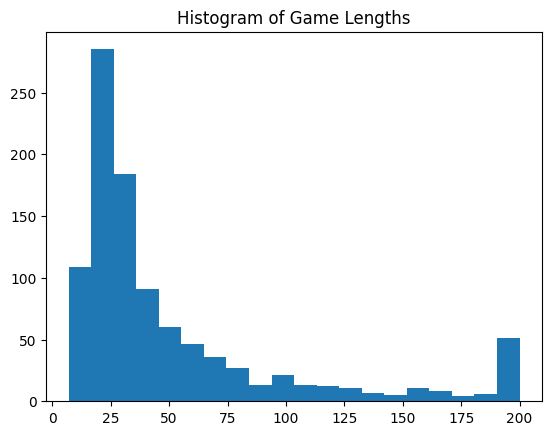

Time 830.298327922821
Game 50
Defender victory rate over the last 50 games: 0.54
Attacker victory rate over the last 50 games: 0.44
Time 863.388909816742
Game 100
Defender victory rate over the last 50 games: 0.42
Attacker victory rate over the last 50 games: 0.58
Time 808.4499781131744
Game 150
Defender victory rate over the last 50 games: 0.54
Attacker victory rate over the last 50 games: 0.46
Time 907.7815029621124
Game 200
Defender victory rate over the last 50 games: 0.6
Attacker victory rate over the last 50 games: 0.4
Time 910.5440299510956
Game 250
Defender victory rate over the last 50 games: 0.62
Attacker victory rate over the last 50 games: 0.38
Time 750.4862122535706
Game 300
Defender victory rate over the last 50 games: 0.48
Attacker victory rate over the last 50 games: 0.52
Time 740.900387763977
Game 350
Defender victory rate over the last 50 games: 0.5
Attacker victory rate over the last 50 games: 0.5
Time 901.7245421409607
Game 400
Defender victory rate over the last 50

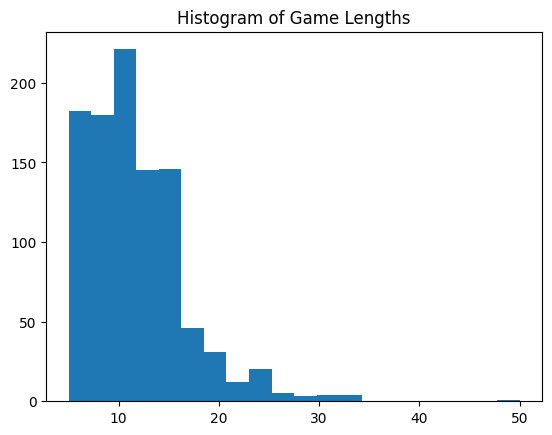

In [23]:
nb_runs=1000

attacker=Odin(5,5,20,[[0.35, 0.2, 0.35, 0.1],[0.2, 0.1, 0.2, 0.5]])
defender=Thor(10)

defender_wins, attacker_wins, avg_length, lengths = runGames(attacker, defender, nb_runs)

print('Defender: '+str(defender))
print('Defender Score: '+str(100*defender_wins/nb_runs)+' %')
print('Attacker: '+str(attacker))
print('Attacker Score: '+str(100*attacker_wins/nb_runs)+' %')
print('Average game length: '+str(round(avg_length,4))+' moves')
plt.hist(lengths, bins=20)
plt.title('Histogram of Game Lengths')
plt.show()

defender=Odin(5,5,20,[[0.35, 0.2, 0.35, 0.1],[0.2, 0.1, 0.2, 0.5]])
attacker=Thor(10)

defender_wins, attacker_wins, avg_length, lengths = runGames(attacker, defender, nb_runs)

print('Defender: '+str(defender))
print('Defender Score: '+str(100*defender_wins/nb_runs)+' %')
print('Attacker: '+str(attacker))
print('Attacker Score: '+str(100*attacker_wins/nb_runs)+' %')
print('Average game length: '+str(round(avg_length,4))+' moves')
plt.hist(lengths, bins=20)
plt.title('Histogram of Game Lengths')
plt.show()